# Synopsis

#### Update 3: I think this implementation is finished. Maybe send me an ATF STELLOPT run though.
* New grid update fixed [the symmetry bug](#Volume-computation-problem-and-solution), I mentioned in June.
* Heliotron is a perfect match to STELLOPT with symmetry off, very close with symmetry on.
* All implementations of the Magnetic Well parameter between DESC and STELLOPT agree on crossing. Educational VMEC disagrees with STELLOPT on one and has a weird curve for ATF. I read through it's github commits, and it looks like fixes some things from the educational branch I'm using on their master branch. Their master branch is missing files to compile locally. Basically, I don't trust educational VMEC branch that much.
* The volume derivative is not necessary for the magnetic well parameter from Greene's paper. I replaced the flux surface label of volume with $\rho$ in the magnetic well formulas derived in the Greene's paper. The output of the magnetic well plot (this version is in purple color) is the same (as the volume derivative version in blue), ignoring the scale. Plots of both are included.

Note this notebook should run pretty quickly. If the plots for many stellarators at once are requested, increase the memory given to jupyter notebook or compute on 3 stellarators at a time instead of 5+.

#### Update 2: works with arbitrary grids and computes magnetic well parameter over multiple flux surfaces simultaneously
Made use of the `surface_integrals` functionality I added while coding the new rotational transform function. The objective will still function in the same way as before if a single rho surface is given as input. However, computing magnetic well over multiple flux surfaces at once offers at least two benefits. It
* Simplifies end user code. They don't have to create routines and loop through things.
* Increases performance. I used to wait for this jupyter notebook to run for 30 minutes to get values to plot. Now it runs in 1 minute.
* Please see [a bug in the grid class](#Volume-computation-problem-and-solution). The solution to this bug for grids with a single rho surface is simple. If the functions I added to `compute.utils` are used then the developer/user doesn't have to worry about it. However, for multiple rho surface grids, the fix isn't as simple.

#### Update 1: alternative version of magnetic well in Landerman paper added.
It seems to have more responsive curves, and it has the same abrupt change as STELLOPT for HELIOTRON. It yields a perfect match for Heliotron.


## the Bad
The curves produced by DESC and STELLOPT for the magnetic well parameter as a function of $\rho$ look different. I think STELLOPT does not implement the well parameter we thought it does. We should just pay attention to the crossing.

## the Good
The magnetic well parameter computed by DESC matches the sign of the magnetic well parameter computed by STELLOPT. This is technically all we need.

The volume computation is now 100% correct. The solution to the bug in the `grid.py` class works, which was necessary to correct volume and dv/d$\rho$. An [explanation to the solution is given here](#Volume-computation-problem-and-solution). Might be useful in case we have run into this bug somewhere else in the code.

All the [plots](#Magnetic-well-plots) of DESC's intermediate quantities are consistent with each other. For every point below, I have confirmed their validity with code tests and math where applicable. We should be sure to preserve these signs if any modifications are made:

* The volume of the torus is exactly quadratic with $\rho$. The derivative of the volume enclosed by the flux surface is exactly linear. For the other stellarators, the volume and derivative are approximately quadratic and linear, respectively. The derivative computations also flatten when the volume curves linearize, and the opposite holds as well. All this matches our expectation that volume ~ $\rho$<sup>2</sup>.
* The volume enclosed by the $\rho$=1 surface matches the volume of the stellarator as computed by `data["V"]` on a grid with a sequence of $\rho$ values.
* The derivative of the thermal pressure average is always negative. This is good since our notion that the well parameter being positive implies stability is only valid when thermal pressure decreases away from the magnetic axis ($\rho$=0). Otherwise negative well parameters would imply stability.
* The derivative of the thermal pressure average looks very similar for stellarators with similar pressure profile inputs.
* Confidence in the new more complicated flux surface average
   - We now properly differentiate under the flux surface average operation. Pushing a volume derivative into a flux surface average requires more care than simply differentiating under the integral. We want to do this in the first place to take advantage of automatic differentiation of `B_r` and `p_r`.
   - Have shown the implementation has the desired additive homomorphism property; meaning average(a + b) = average(a) + average(b). Sanity check for correctness.
   - Confirmed `jnp.mean(f) / jnp.mean(`$\sqrt{g}$ `)`  always = `jnp.sum(dtdz * f) /` dv/d$\rho$ . Helps confirm dv/d$\rho$ is correct among other things.
   - Proved that this new flux surface average is an identity operation for the average of any quantity constant over the surface.
* The thermal pressure is a flux surface function; it is constant on a surface of constant rho. Therefore, the average of thermal pressure over a flux surface should be an identity operation. This is reflected in the code. Also, we take advantage of the homomorphism discussed above to avoid an unnecessary flux surface average operation.
* The derivative of the magnetic pressure average is positive (negative) precisely when B<sup>2</sup> average is increasing (decreasing). We should expect this since magnetic pressure ~ B<sup>2</sup>, and its average over a surface should likely share that relation.
* No jacobian sign errors. FYI: we always want them to be positive here.

## the Pretty
This notebook should make it easy to inspect intermediate variables in the `MagneticWell` class as well as compute quantities for all the stellarators in a concise manner. Add an entry to the dictionary and everything is automatic.

~~Given this, if the equilibrium solutions DESC and STELLOPT are computing magnetic well parameters on are indeed the same, I think any issue must be in the automatic differentiation of `B_r` and `p_r`. Perhaps there is a bug with computing things on $\rho$=constant surfaces like the `grid.py` class? There isn't much room for error anywhere else.~~

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from netCDF4 import Dataset
import pickle
import scipy.io as sio
import desc.io

from desc.compute import compute_geometry, data_index
from desc.equilibrium import Equilibrium
from desc.grid import LinearGrid
from desc.objectives import MagneticWell
from desc.plotting import plot_surfaces
from desc.transform import Transform

DESC version 0.5.1+98.gfbd3afe.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 7.49 GB available memory


In [3]:
np.set_printoptions(precision=4, floatmode="fixed")

In [4]:
class MagneticWellVisual:
    """
    To print and plot more (less) quantities, add (remove) them to the dict
    returned from MagneticWell.compute().
    Everything else is automatic.
    """

    def __init__(
        self,
        name,
        eq=None,
        use_pickle=True,
        rho=np.linspace(1 / 64, 1, 64),
    ):
        """
        Make a MagneticWellVisual from either the provided equilibrium
        or the final equilibrium loaded from the output.h5 solution.

        Parameters
        ----------
        name : str
            Name of the equilibrium.
        eq : Equilibrium
            The equilibrium.
        use_pickle : bool
            True to use compute values from a previous run stored in pickle file; False to recompute.
        rho : ndarray
            The flux surface values to compute the magnetic well on.
        """
        self.name = name
        if eq is None:
            eq = desc.io.load(
                load_from="../examples/DESC/" + name + "_output.h5"
            )[-1]
        self.eq = eq

        if use_pickle:
            with open(name + " DESC magwell.pkl", "rb") as file:
                self.st = pickle.load(file)
            self.rho = self.st["volume"][0]
            self.has_values = True
        else:
            # values are tuples of (x[i], y[i]) of plotable data
            # y points are cached when compute_plot() is called
            self.st = dict()
            try:
                mat = sio.loadmat(name + "_magwell.mat")
                self.st["0. STELLOPT Magnetic Well"] = mat["rho"], mat["magwell"]
                rho = mat["rho"]
            except FileNotFoundError:
                pass

            try:
                f = Dataset("../iota/edu-vmec/input-iota/wout_" + name + ".nc")
                # print(f.variables.keys())
                vmec_rho = np.sqrt(
                    f.variables["phi"] / np.array(f.variables["phi"])[-1]
                )
                vmec_well = np.asarray(f.variables["DWell"])
                self.st["0. VMEC Magnetic Well"] = vmec_rho, vmec_well
            except FileNotFoundError:
                pass

            self.rho = rho
            self.has_values = False

    def print_values(self, grid=None):
        """
        Parameters
        ----------
        grid : LinearGrid
            The grid used for a MagneticWell objective.
            The default grid=None uses the rho=1 flux surface.
        """
        print(self.name)
        print(self.eq)
        mw = MagneticWell(eq=self.eq, grid=grid)
        print("grid.spacing(dr,dt,dz)", mw.grid.spacing[0])
        m = mw.compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        for key, val in sorted(m.items()):
            print(key, val)
        self._print_data_V()
        print()

    def _print_data_V(self):
        """
        Print the volume of the stellarator device as computed by data["V"].
        Should match V surface integral when the default grid with rho = 1
        is used to construct the MagneticWell() object.
        """
        grid = LinearGrid(
            L=self.eq.L_grid,
            M=self.eq.M_grid,
            N=self.eq.N_grid,
            NFP=self.eq.NFP,
            sym=self.eq.sym,
        )
        R_transform = Transform(
            grid, self.eq.R_basis, derivs=data_index["sqrt(g)"]["R_derivs"], build=True
        )
        Z_transform = Transform(
            grid, self.eq.Z_basis, derivs=data_index["sqrt(g)"]["R_derivs"], build=True
        )
        data = compute_geometry(self.eq.R_lmn, self.eq.Z_lmn, R_transform, Z_transform)
        print('data["V"]', data["V"])

    # same as other compute_plot but builds plot through computing on single rho surfaces
    # def compute_plot(self):
    #     """Compute and cache MagneticWell.compute() values."""
    #     if self.has_values:
    #         return
    #
    #     for i in range(len(self.rho)):
    #         m = MagneticWell(
    #             eq=self.eq,
    #             grid=LinearGrid(
    #                 M=self.eq.M_grid,
    #                 N=self.eq.N_grid,
    #                 NFP=self.eq.NFP,
    #                 sym=self.eq.sym,
    #                 rho=self.rho[i],
    #             ),
    #         ).compute(
    #             self.eq.R_lmn,
    #             self.eq.Z_lmn,
    #             self.eq.L_lmn,
    #             self.eq.p_l,
    #             self.eq.i_l,
    #             self.eq.c_l,
    #             self.eq.Psi,
    #         )
    #         for key, val in m.items():
    #             self.st.setdefault(key, (self.rho, np.empty_like(self.rho)))[1][i] = val
    #     self.has_values = True

    def compute_plot(self):
        """Compute and cache MagneticWell.compute() values."""
        if self.has_values:
            return

        m = MagneticWell(
            eq=self.eq,
            grid=LinearGrid(
                M=self.eq.M_grid,
                N=self.eq.N_grid,
                NFP=1,  # required for grid.num_rho != 1
                sym=self.eq.sym,
                rho=self.rho,
            ),
        ).compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.c_l,
            self.eq.Psi,
        )
        for key, val in m.items():
            self.st[key] = self.rho, val
        self.has_values = True

    def save(self):
        """Save computed values to pickle file."""
        with open(self.name + " DESC magwell.pkl", "wb") as file:
            pickle.dump(self.st, file)

    @staticmethod
    def plot(name, st):
        """
        Parameters
        ----------
        name : str
            Name of the equilibrium.
        st : dict
            Keys are quantities to plot, values are tuple of (x-values, y-values).
        """
        """Plot all quantities from compute_plot() in st."""
        fig, ax = plt.subplots(ncols=len(st), figsize=(len(st) * 8, 5))
        for i, e in enumerate(sorted(st.items())):
            key, val = e
            x, y = val
            if key == "0. VMEC Magnetic Well":
                x = x[:-3]
                y = y[:-3]
            color = MagneticWellVisual._color(key)
            ax[i].scatter(x, y, color=color, s=(5 if len(x) > 128 else 10))
            ax[i].plot(x, y, color=color)
            ax[i].set(xlabel=r"$\rho$", ylabel=key, title=name)
            if "Magnetic Well" in key:
                ax[i].set(yscale="symlog" if np.any(y < 0) else "log")
                ax[i].axhline(color="tab:red")
            ax[i].grid()

    @staticmethod
    def _color(key):
        """Return the correct plot color."""
        if "0." in key:
            return "tab:green"
        if "1." in key:
            return "tab:orange"
        if "2." in key:
            return "tab:purple"
        return "tab:blue"

In [5]:
torus = MagneticWellVisual("torus", Equilibrium())
dshape = MagneticWellVisual("DSHAPE")
heliotron = MagneticWellVisual("HELIOTRON")
atf = MagneticWellVisual("ATF")
axisym = MagneticWellVisual("AXISYM")
stellarators = (torus, dshape, heliotron, atf, axisym)

/home/kaya/Documents/edu/pton/plasma/desc/DESC/desc/configuration.py:344: UserWarning: Must specify either iota or current. Using default profile of iota=0.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/desc/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


# Equilibrium plots

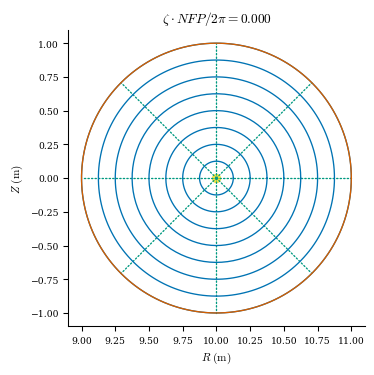

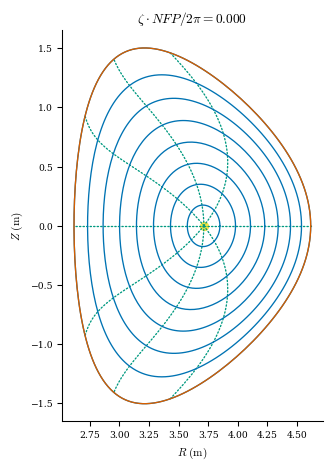

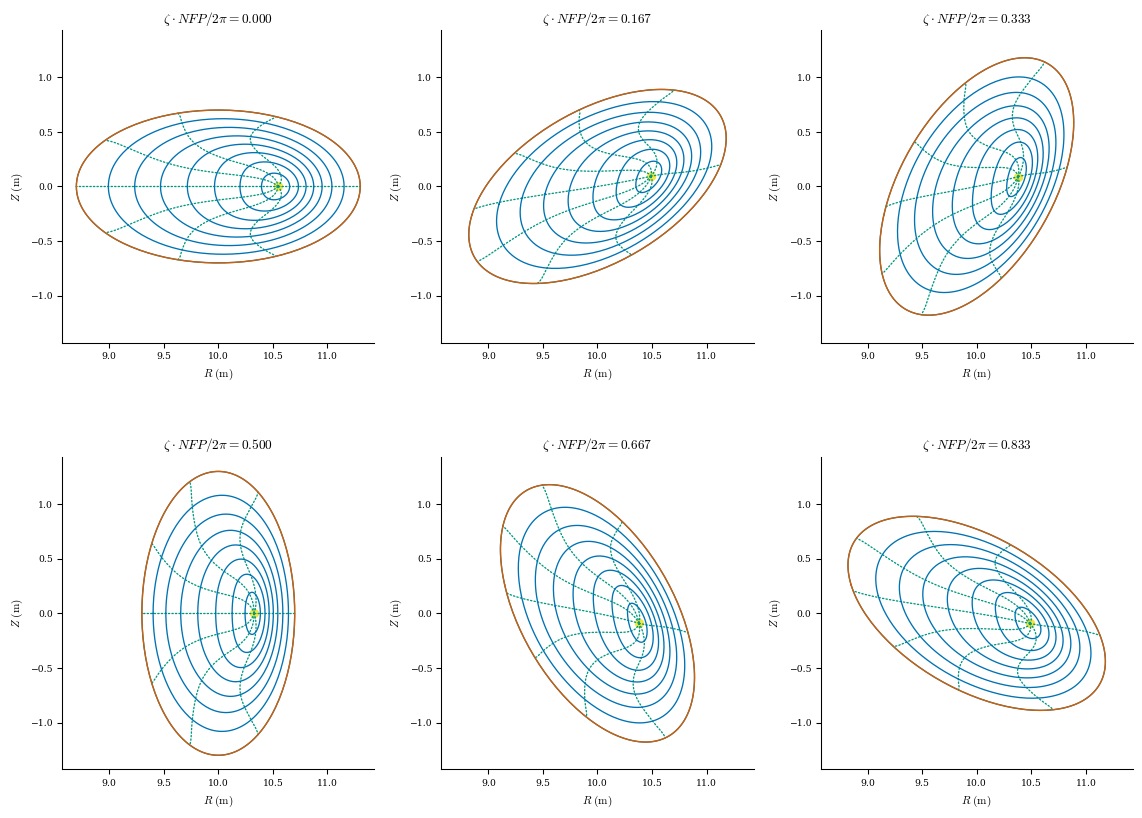

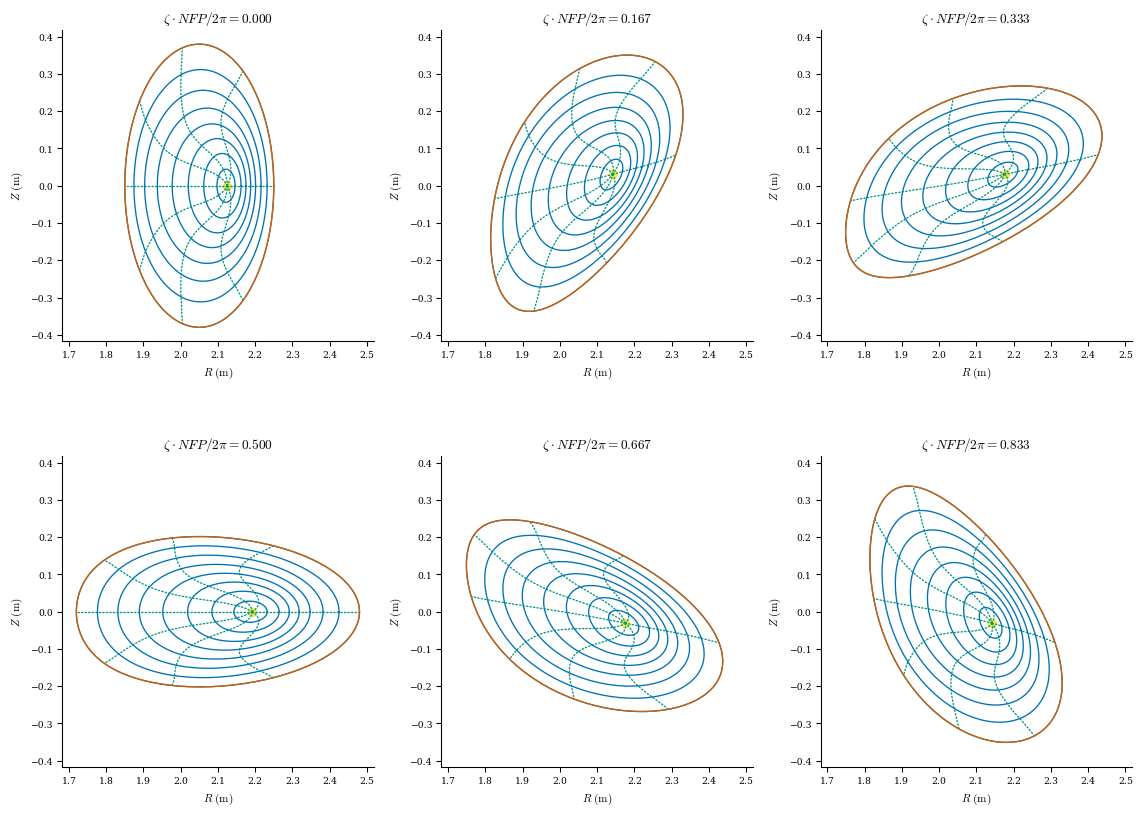

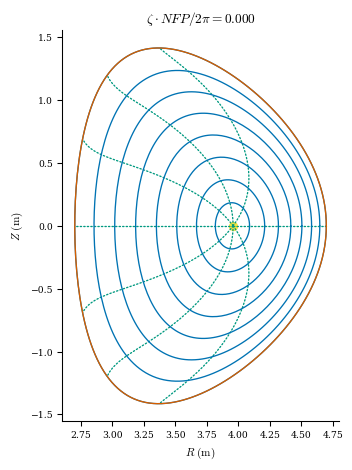

In [6]:
# to make sure equilibrium were solved correctly on my computer
for s in stellarators:
    plot_surfaces(s.eq)

# $\rho$ = 1 flux surface

In [7]:
for s in stellarators:
    s.print_values()

torus
Equilibrium at 0x7f2c601c1520 (L=1, M=1, N=0, NFP=1, sym=False, spectral_indexing=ansi)
Precomputing transforms
grid.spacing(dr,dt,dz) [1.0000 1.2566 6.2832]
1. DESC Magnetic Well: M. Landreman eq. 4.19 [0.0000]
2. DESC Magnetic Well: rho * d/drho [-3.2159e-16]
3. DESC Magnetic Well: V * d/dv [-1.6080e-16]
B square average [0.1013]
d(magnetic pressure average)/drho [-3.2584e-17]
d(thermal pressure)/drho [0.0000]
d(total pressure average)/drho [-3.2584e-17]
d(total pressure average)/dvolume [-8.2537e-20]
d^2(volume)/d(rho)^2 [394.7842]
dtdz [39.4784]
dvolume/drho [394.7842]
volume [197.3921]
data["V"] 197.39208802178715

DSHAPE
Equilibrium at 0x7f2c13b00e80 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
Precomputing transforms
grid.spacing(dr,dt,dz) [1.2599 0.1466 7.9163]
1. DESC Magnetic Well: M. Landreman eq. 4.19 [0.0000]
2. DESC Magnetic Well: rho * d/drho [0.0629]
3. DESC Magnetic Well: V * d/dv [0.0369]
B square average [0.0575]
d(magnetic pressure average)/drho

# Magnetic well plots

In [8]:
for s in stellarators:
    s.compute_plot()

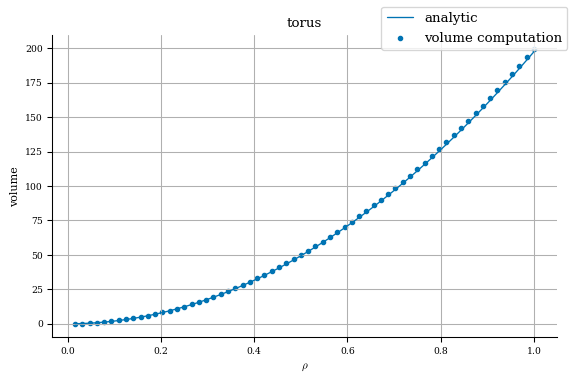

In [9]:
# compare volume computation to known analytic case for torus
fig, ax = plt.subplots()
y = "volume"
rho, volume = torus.st[y]
ax.scatter(rho, volume, label=y + " computation", s=10)
ax.plot(rho, 20 * (np.pi * rho) ** 2, label="analytic")
ax.set(xlabel=r"$\rho$", ylabel=y, title=torus.name)
ax.grid()
fig.legend()

/tmp/ipykernel_14992/2344574965.py:199: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i].set(yscale="symlog" if np.any(y < 0) else "log")
/home/kaya/Software/miniconda3/envs/fuze/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


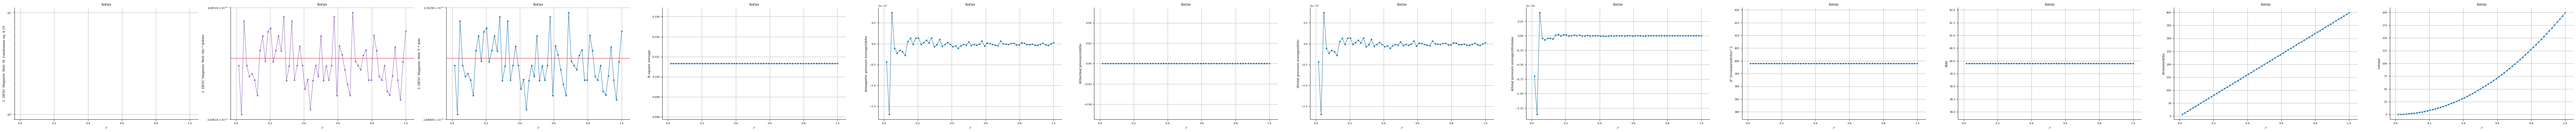

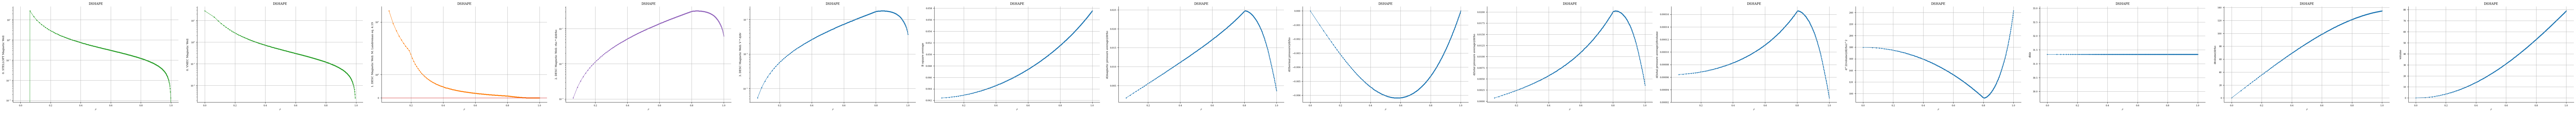

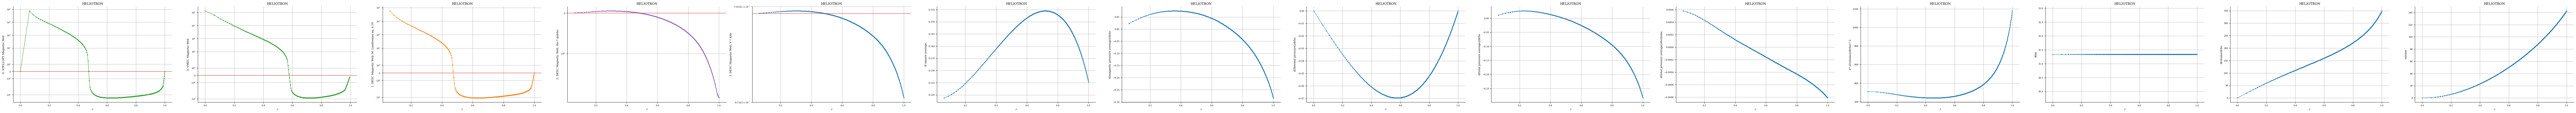

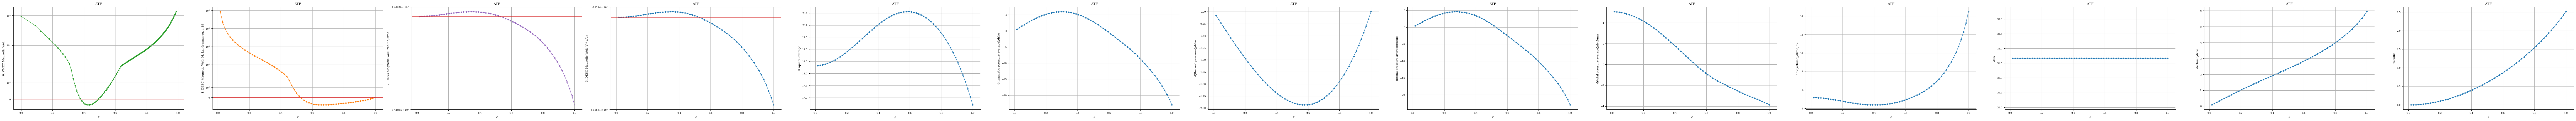

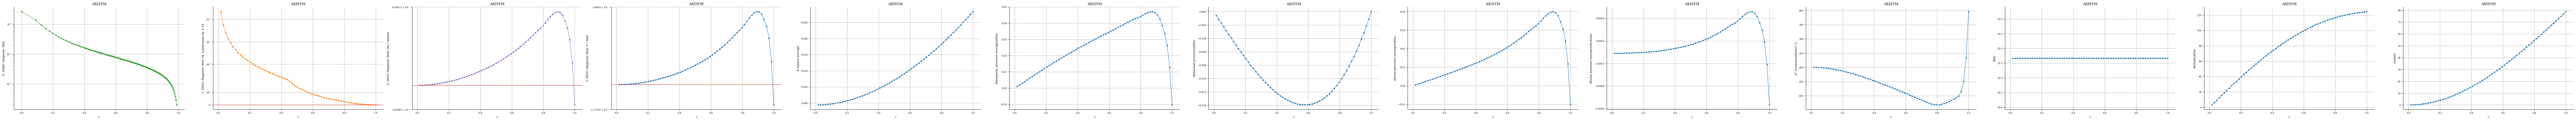

In [10]:
# the red line denotes the y=0 axis
# green plots are STELLOPT or educational VMEC data
for s in stellarators:
    MagneticWellVisual.plot(s.name, s.st)

In [11]:
for s in stellarators:
    s.save()

# Volume computation problem and solution
In `MagneticWell.compute()`, the volume computation relies on the quantity d$\theta$ * d$\zeta$. This is obtained from splicing `grid.spacing`. The grid class takes advantage of things like reducing duplicated node weight, stellarator symmetry, and the number of field periods to reduce the amount of computation.

The problem is that, in the grid class's current implementation, the modifications made to `grid.spacing` to take advantage of symmetry and NFP do not preserve the value of d$\theta$ * d$\zeta$. So independently plucking out d$\theta$ * d$\zeta$ from a grid will not give the value its name implies.

Why is this? Because rescaling is done to preserve the full volume, or the weights (d$\rho$ * d$\theta$ * d$\zeta$) so that `grid.spacing.prod(axis=1).sum()` = 4$\pi$<sup>2</sup>, at the expense of changing d$\theta$ * d$\zeta$. Here's a visual:

In [12]:
# For any constant rho surface and NFP=1, grid.spacing is going
# to be an M*N length stack of the row vector (1, 2pi/M, 2pi/N).
g1 = LinearGrid(M=2, N=2, rho=np.array(1))
print(g1.spacing)
print()
# When NFP != 1, the values of drho are increased (decreased) while
# dtheta*dzeta decreases (increases).
# That's why the wrong volume was being computed for the heliotron with NFP > 1.
NFP = np.random.random_sample() * 100
print("NFP:", NFP)
g2 = LinearGrid(M=2, N=2, NFP=NFP, rho=np.array(1))
print(g2.spacing)

# the good thing is that the differential volume drho*dtheta*dzeta is preserved
# since that was the (main?) goal of the rescaling
assert np.allclose(g1.spacing.prod(axis=1), g2.spacing.prod(axis=1))
# and that, because rho=constant forces the drho vector to = 1 (with NFP=1),
# grid.weights is actually the value we expect from dtheta*dzeta (for any NFP).
if g1.num_rho == 1:
    assert np.allclose(g1.spacing.prod(axis=1), g1.spacing[:, 1:].prod(axis=1))
assert np.allclose(g1.spacing.prod(axis=1), g1.weights)  # definition of weights

[[1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]
 [1.0000 1.2566 1.2566]]

NFP: 75.40269045072856
[[4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089 0.0704]
 [4.2247 5.3089

## Solution

On grids which are defined completely by a single rho surface (`grid.num_rho = 1`), the correct volume will be computed $\forall NFP \in \mathbb{R}^{+}$, if we take d$\theta$ * d$\zeta$ to be `grid.weights` instead of `grid.spacing[:, 1:].prod(axis=1)`.

On grids which are defined over a range of rho surfaces (`grid.num_rho != 1`) this will not work because d$\rho$ != 1 on those grids. A general solution follows for computing the correct value for d$\theta$ * d$\zeta$ to other grids $g \in Grid : g.num\_rho \in \mathbb{N}$.
* Let $g1 \in Grid : g1.NFP = 1$ and $g2 \in Grid : g2.NFP \in \mathbb{R}^{+}$. Then given g2, d$\theta$ * d$\zeta$ = `g2.weights / g1.spacing[:, 0]`.
* I don't know how to retrieve g1.d$\rho$ from g2, other than storing it during grid construction.
* Until this can be fixed, any computation which requires differential surface elements (i.e. flux surface averages require the columns from `grid.spacing`) will yield incorrect quantities $\forall g \in Grid : g.num\_rho \in \mathbb{N} \setminus {1}\ and\ g.NFP \in \mathbb{R}^{+} \setminus {1}$.
* Which is disappointing because bulk flux surface averaging was a performance improvement for the end user (me wanting to compute magnetic well over many surfaces).


### Edit: New grid fix for symmetry fixes the issue discussed below.
The next, and last to my knowledge, source of error in the volume is the stellarator symmetry boolean. `enforce_symmetry()` again modifies d$\theta$ * d$\zeta$. Visual given below.

The error in computed volume that results from this is much smaller than the NFP error fixed above. The nodes with $\theta$ > $\pi$ are removed and so too are the spacings in the grid that correspond to those nodes. Now because `grid.spacing` is missing these nodes, to preserve the overall volume in ($\rho$, $\theta$, $\zeta$) space (`grid.weights.sum()`), the differential volume d$\rho$ * d$\theta$ * d$\zeta$ of the remaining spaces is increased so that the sum is still 4$\pi$<sup>2</sup>. This makes sense since we do want to increase the weight of the nodes 0 to $\pi$ to double count for the removed nodes. This process has preserving the volume d$\rho$ * d$\theta$ * d$\zeta$ in mind. It's not clear to me if a different scale factor (other than 4$\pi$<sup>2</sup>) would be better to preserve an area element d$\theta$ * d$\zeta$. Might be dependent on $\rho$.

~~In any case, the solution implemented here is to force stellarator symmetry to `False`. This is not ideal since it can simplify the computation of the transforms and such. An alternative could be to just recreate the grid with the nodes that were removed from `enforce_symmetry()` in the `MagneticWell` class and use this grid just for the volume computation. This could allow the grid with symmetry to still be used elsewhere.~~

In [13]:
g3 = LinearGrid(M=2, N=2, sym=True, rho=np.array(1))
print(g3.spacing)

[[1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]
 [1.2599 1.3194 1.5833]]


## Nice plot of Heliotron well

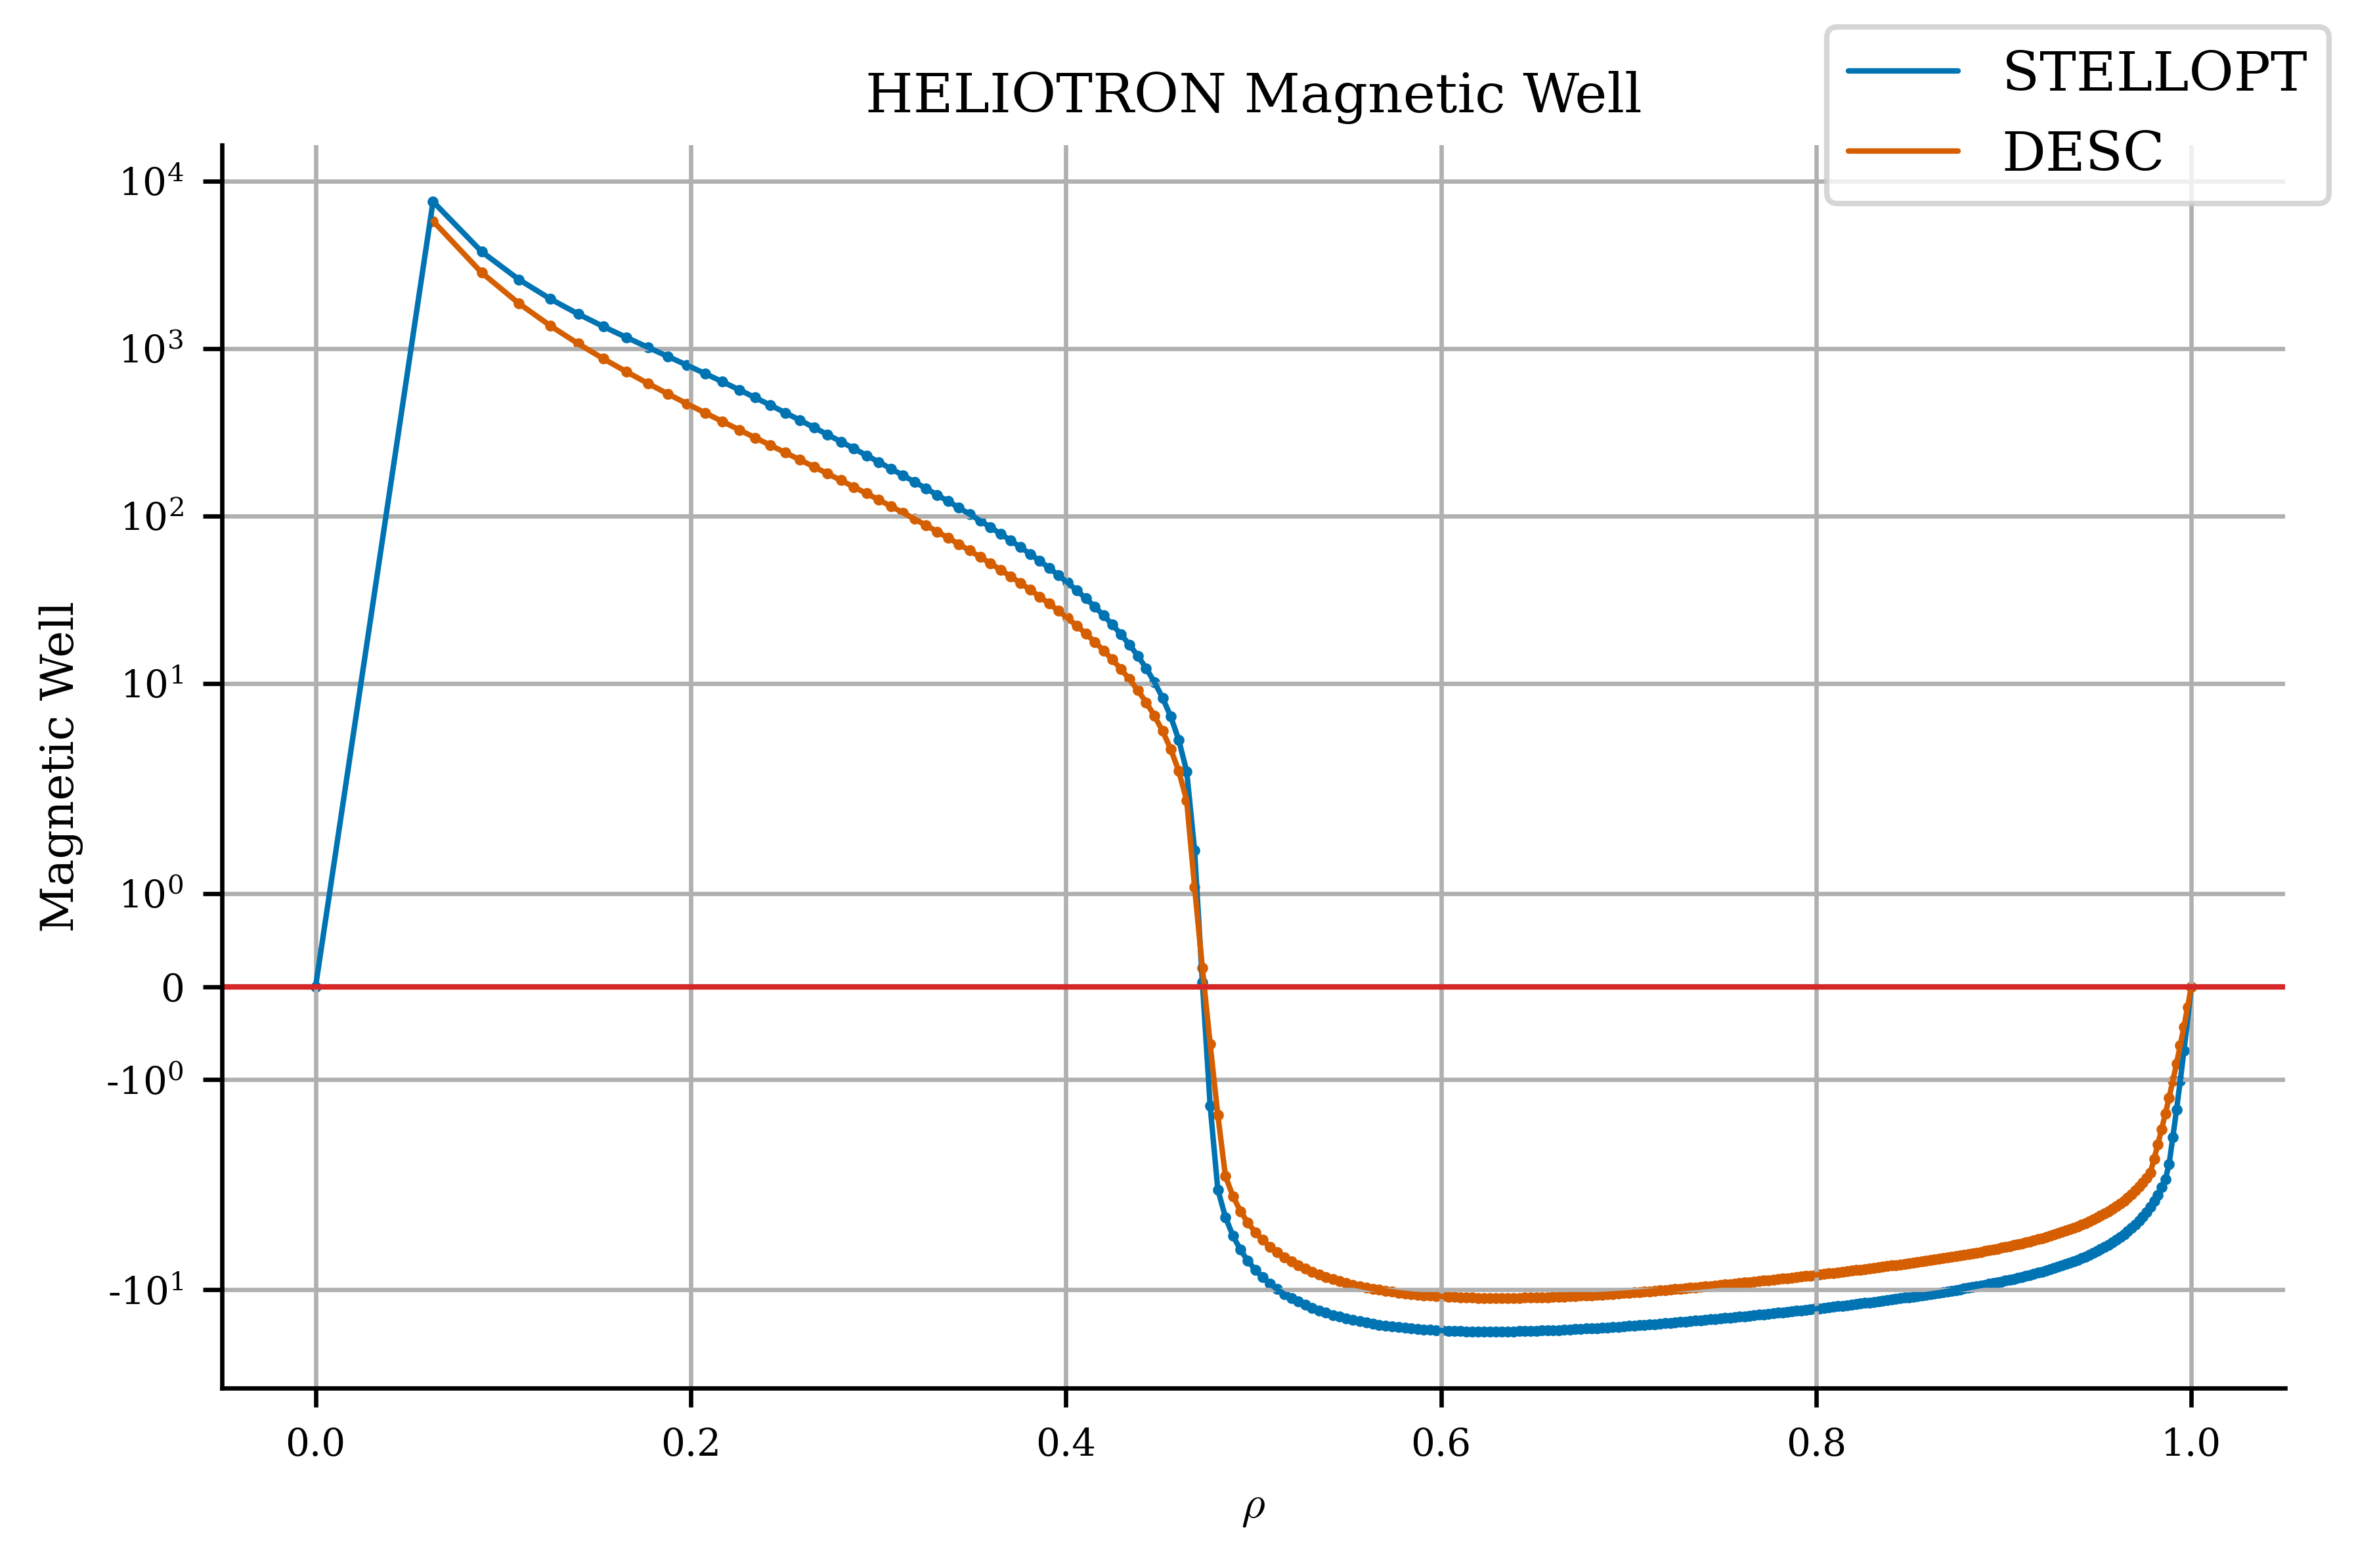

In [14]:
fig, ax = plt.subplots(dpi=600)
y = "Magnetic Well"
rho, stellopt_well = heliotron.st["0. STELLOPT Magnetic Well"]
_rho, desc_well = heliotron.st["1. DESC Magnetic Well: M. Landreman eq. 4.19"]
assert np.allclose(rho, _rho)

ax.plot(rho, stellopt_well, label="STELLOPT")
ax.plot(rho, desc_well, label="DESC")
ax.scatter(rho, stellopt_well, s=1)
ax.scatter(rho, desc_well, s=1)
ax.set(yscale="symlog", xlabel=r"$\rho$", ylabel=y, title=heliotron.name + " " + y, facecolor="white")
ax.axhline(color="tab:red")
ax.grid()
fig.legend()
fig.savefig("Heliotron magnetic well comparison.png")